In [4]:
# from google.colab import drive
# drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
SIZE = 256
EPOCH = 200
BATCH_SIZE = 16
test_ratio = 0.2
INPUT_SHAPE = (SIZE, SIZE, 3) 
MODEL_NAME = 'mobilenet_1.h5'
TB_FILE = 'mobilenet_1'

In [6]:
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="logs\\{}".format(TB_FILE))

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils import np_utils
plt.style.use('classic')

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense

import os
import cv2
from PIL import Image
import numpy as np

In [8]:
# load train data

image_directory = '/content/drive/MyDrive/Dataset/train/'
# image_directory = 'archive/train/'
dataset = []
label = [] 

badimgs = os.listdir(image_directory + 'not-good/')
for i, image_name in enumerate(badimgs):   
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'not-good/' + image_name)
        image = cv2.resize(image , (SIZE, SIZE))
        image = image/255.0
        dataset.append(image)
        label.append(1)


goodimgs = os.listdir(image_directory + 'good/')
for i, image_name in enumerate(goodimgs):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'good/' + image_name)
        image = cv2.resize(image , (SIZE, SIZE))
        image = image/255.0
        dataset.append(image)
        label.append(0)


dataset = np.array(dataset)
label = np.array(label)

print(dataset.shape)
print(label.shape)

(300, 256, 256, 3)
(300,)


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = test_ratio, random_state = 0) 

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test)

(240, 256, 256, 3)
(240,)
(60, 256, 256, 3)
[0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0]


In [10]:
# oversampling
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler

# Create an oversampler
# smk = SMOTETomek(random_state=42)
ovs = RandomOverSampler(random_state=0)

dataset2d = X_train.reshape(X_train.shape[0], -1)

# Fit and transform the data
dataset1, y_train = ovs.fit_resample(dataset2d, y_train)
X_train = dataset1.reshape(dataset1.shape[0], SIZE, SIZE, 3)

print(X_train.shape)
print(y_train.shape)
# print(y_train)

(398, 256, 256, 3)
(398,)


In [11]:
# data augmentation
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=360)
datagen.fit(X_train)

In [12]:
import tensorflow as tf

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    include_top=False,
    pooling='avg'
)

# base_model = tf.keras.applications.ResNet50(
#     weights='imagenet',
#     include_top=False,
#     pooling='avg'
# )

base_model.trainable = False 

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),        
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,979,649
Trainable params: 721,665
Non-train

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    steps_per_epoch=len(X_train) / BATCH_SIZE,
                    epochs=EPOCH,
                    validation_data=(X_test, y_test),
                    callbacks=[tensorboard],
                    )


model.save(MODEL_NAME)

train_score = model.evaluate(X_train, y_train, verbose=0)
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Train Loss:{0:.3f}'.format(train_score[0]))
print('Train accuracy:{0:.3}'.format(train_score[1]))
print('Test Loss:{0:.3f}'.format(test_score[0]))
print('Test accuracy:{0:.3}'.format(test_score[1]))

Epoch 1/200
24/24 [==============================] - 19s 302ms/step - loss: 0.7106 - accuracy: 0.5427 - val_loss: 0.7711 - val_accuracy: 0.4000
Epoch 2/200
24/24 [==============================] - 6s 225ms/step - loss: 0.6959 - accuracy: 0.5553 - val_loss: 0.5771 - val_accuracy: 0.8333
Epoch 3/200
24/24 [==============================] - 7s 264ms/step - loss: 0.6809 - accuracy: 0.5829 - val_loss: 0.6774 - val_accuracy: 0.6167
Epoch 4/200
24/24 [==============================] - 5s 215ms/step - loss: 0.6499 - accuracy: 0.6080 - val_loss: 0.8266 - val_accuracy: 0.3667
Epoch 5/200
24/24 [==============================] - 6s 252ms/step - loss: 0.6662 - accuracy: 0.5930 - val_loss: 0.5382 - val_accuracy: 0.7667
Epoch 6/200
24/24 [==============================] - 7s 268ms/step - loss: 0.6763 - accuracy: 0.5930 - val_loss: 0.9044 - val_accuracy: 0.2500
Epoch 7/200
24/24 [==============================] - 5s 209ms/step - loss: 0.6741 - accuracy: 0.5854 - val_loss: 0.9426 - val_accuracy: 0.250

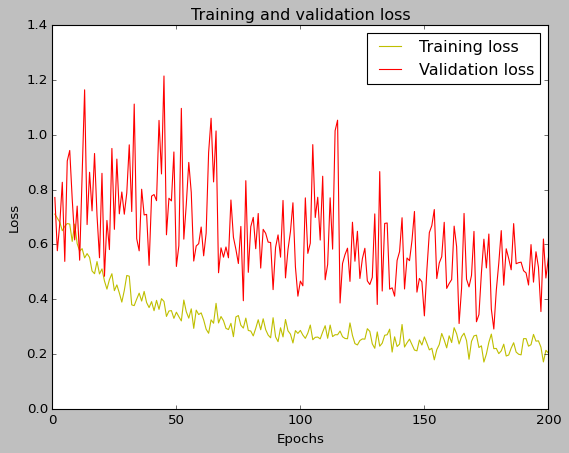

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

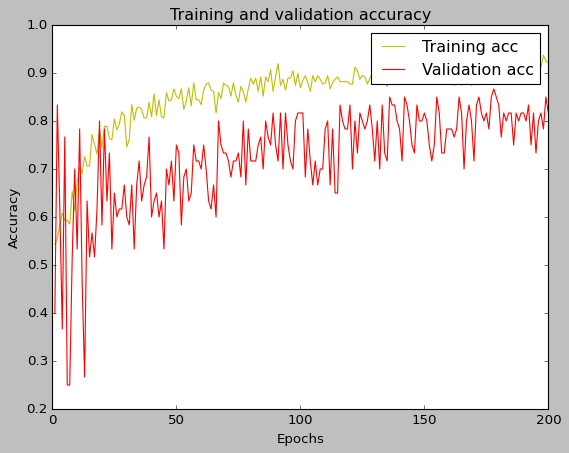

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
# calculate precision and recall
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
print('F1: {:.2f}'.format(f1_score(y_test, y_pred)))
print('ROC AUC: {:.2f}'.format(roc_auc_score(y_test, y_pred)))
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred))

2/2 [==============================] - 1s 60ms/step
Accuracy: 0.82
Precision: 0.44
Recall: 0.89
F1: 0.59
ROC AUC: 0.85
Confusion Matrix:  [[41 10]
 [ 1  8]]


In [18]:
mythreshold=0.5
from sklearn.metrics import confusion_matrix

y_pred = (model.predict(X_test)>= mythreshold).astype(int)
cm=confusion_matrix(y_test, y_pred)  
print(cm)

y_pred = (model.predict(dataset)>= mythreshold).astype(int)
cm=confusion_matrix(label, y_pred)  
print(cm)

2/2 [==============================] - 0s 58ms/step
[[41 10]
 [ 1  8]]
10/10 [==============================] - 1s 99ms/step
[[202  48]
 [  5  45]]


In [19]:
# test_image_directory = 'archive/'
test_image_directory = '/content/drive/MyDrive/Dataset/'
test_dataset = []

testimg = os.listdir(test_image_directory + 'test/')
for i, image_name in enumerate(testimg):   
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(test_image_directory + 'test/' + image_name)
        image = cv2.resize(image , (SIZE, SIZE))
        image = image/255.0
        test_dataset.append(image)

test_dataset = np.array(test_dataset)

In [20]:
from keras.models import load_model
# load model
model = load_model(MODEL_NAME)

In [21]:
mythreshold=0.5
test_y_preds = (model.predict(test_dataset)>= mythreshold).astype(int)
# save to csv
import pandas as pd
df = pd.DataFrame(test_y_preds)
df.to_csv('submission.csv', index=False)

6/6 [==============================] - 2s 166ms/step


In [22]:
!zip -r /content/logs_mobilenet_1.zip /content/logs\\mobilenet_1


  adding: content/logs\mobilenet_1/ (stored 0%)
  adding: content/logs\mobilenet_1/train/ (stored 0%)
  adding: content/logs\mobilenet_1/train/events.out.tfevents.1682102104.ed05f5c2b37b.151.0.v2 (deflated 92%)
  adding: content/logs\mobilenet_1/validation/ (stored 0%)
  adding: content/logs\mobilenet_1/validation/events.out.tfevents.1682102121.ed05f5c2b37b.151.1.v2 (deflated 80%)
